# Retail sales Modeling
This notebook contains:

Baseline: Start with a simple model like ARIMA  establish a baseline.

Advanced: Build a more sophisticated model using a machine learning framework like XGBoost and LightGBM . 
Frame the problem as a regression task.

Evaluation: The primary metric will likely be Mean Absolute Error (MAE) and  Root Mean Squared Error (RMSE). Explain why these metrics are suitable for this problem.



### ARIMA

In [1]:
import pandas as pd

# Load the feature-engineered dataset
data = pd.read_parquet(r"C:\Users\navya\OneDrive\Documents\Retail-sales-forecasting\data\cleaned\merged_feature_engineered.parquet", engine="pyarrow")
print("Data loaded with shape:", data.shape)


data.head()


Data loaded with shape: (3054348, 22)


,id,date,store_nbr,family,sales,onpromotion,city,state,type,cluster,...,dcoilwtico,sales_log,day_of_week,month,year,week_of_year,sales_last_week,sales_two_weeks_ago,rolling_4_weeks,rolling_8_weeks
0,0,2013-01-01,1,AUTOMOTIVE,0.0,0,Quito,Pichincha,D,13,...,93.14,0.000000,1,1,2013,1,NaN,NaN,NaN,NaN
1,1782,2013-01-02,1,AUTOMOTIVE,2.0,0,Quito,Pichincha,D,13,...,93.14,1.098612,2,1,2013,1,NaN,NaN,0.000000,0.000000
2,3564,2013-01-03,1,AUTOMOTIVE,3.0,0,Quito,Pichincha,D,13,...,92.97,1.386294,3,1,2013,1,NaN,NaN,1.000000,1.000000
3,5346,2013-01-04,1,AUTOMOTIVE,3.0,0,Quito,Pichincha,D,13,...,93.12,1.386294,4,1,2013,1,NaN,NaN,1.666667,1.666667
4,7128,2013-01-05,1,AUTOMOTIVE,5.0,0,Quito,Pichincha,D,13,...,93.12,1.791759,5,1,2013,1,NaN,NaN,2.000000,2.000000


### Aggregate to Weekly Level

Since ARIMA requires a continuous time series, we’ll aggregate sales per store and family per week.

In [2]:
import pandas as pd

# Aggregate weekly data for each store-family pair
weekly_data = (
    data.groupby(['store_nbr', 'family', pd.Grouper(key='date', freq='W')])
        .agg({'sales':'sum', 
              'onpromotion':'sum', 
              'transactions':'sum', 
              'is_holiday':'max', 
              'dcoilwtico':'mean'})
        .reset_index()
)

print("Weekly aggregated data shape:", weekly_data.shape)
weekly_data.head()


C:\Users\navya\AppData\Local\Temp\ipykernel_240408\1297883619.py:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  data.groupby(['store_nbr', 'family', pd.Grouper(key='date', freq='W')])


Weekly aggregated data shape: (431244, 8)


,store_nbr,family,date,sales,onpromotion,transactions,is_holiday,dcoilwtico
0,1,AUTOMOTIVE,2013-01-06,15.0,0,7836.0,1.0,93.101667
1,1,AUTOMOTIVE,2013-01-13,13.0,0,11093.0,1.0,93.442857
2,1,AUTOMOTIVE,2013-01-20,13.0,0,10820.0,0.0,94.875714
3,1,AUTOMOTIVE,2013-01-27,16.0,0,10628.0,0.0,95.365714
4,1,AUTOMOTIVE,2013-02-03,14.0,0,10808.0,0.0,97.368571


### Choose One Store and Product for Baseline

To make the ARIMA model simple, we’ll focus on one time series first — say, Store 1 - AUTOMOTIVE.

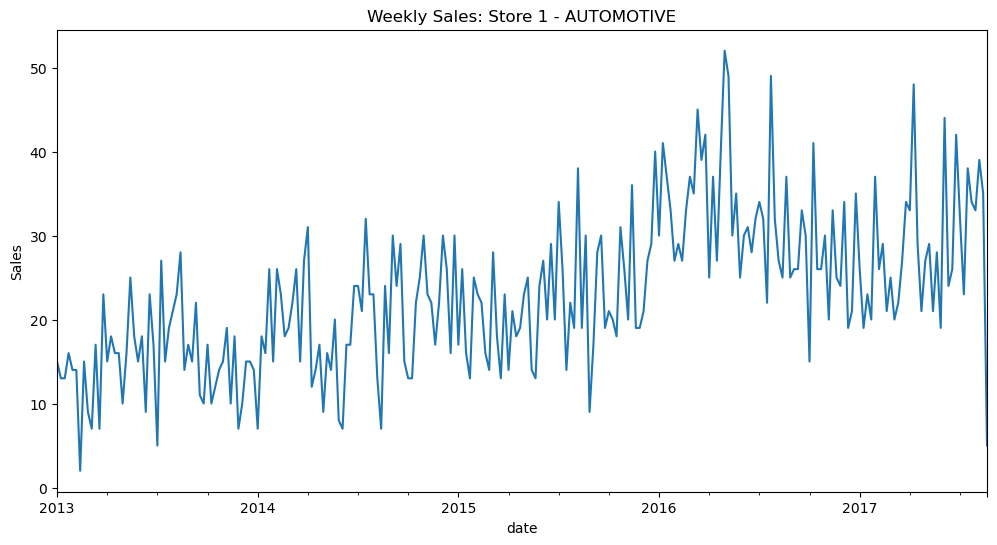

In [3]:
# Select one store and product
store_prod_data = weekly_data[(weekly_data['store_nbr']==1) & (weekly_data['family']=='AUTOMOTIVE')].copy()
store_prod_data.set_index('date', inplace=True)

# Plot to visualize the trend
import matplotlib.pyplot as plt

store_prod_data['sales'].plot(figsize=(12,6), title='Weekly Sales: Store 1 - AUTOMOTIVE')
plt.ylabel('Sales')
plt.show()


### Train Test split
We’ll keep the last 3 months for testing, and the rest for training.

In [4]:
train = store_prod_data.iloc[:-12]
test = store_prod_data.iloc[-12:]

print("Train shape:", train.shape)
print("Test shape:", test.shape)


Train shape: (230, 7)
Test shape: (12, 7)


### Fit ARIMA model

In [5]:
pip install pmdarima

Note: you may need to restart the kernel to use updated packages.


In [6]:
from pmdarima import auto_arima

# Fit ARIMA model
model = auto_arima(
    train['sales'],
    seasonal=True,
    m=52,  # weekly seasonality (52 weeks/year)
    trace=True,
    error_action='ignore',
    suppress_warnings=True
)

print(model.summary())


Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[52] intercept   : AIC=1543.104, Time=23.26 sec
 ARIMA(0,1,0)(0,0,0)[52] intercept   : AIC=1655.020, Time=0.05 sec
 ARIMA(1,1,0)(1,0,0)[52] intercept   : AIC=1587.128, Time=4.20 sec
 ARIMA(0,1,1)(0,0,1)[52] intercept   : AIC=1536.652, Time=5.62 sec
 ARIMA(0,1,0)(0,0,0)[52]             : AIC=1653.021, Time=0.05 sec
 ARIMA(0,1,1)(0,0,0)[52] intercept   : AIC=1534.662, Time=0.12 sec
 ARIMA(0,1,1)(1,0,0)[52] intercept   : AIC=1536.651, Time=6.89 sec
 ARIMA(0,1,1)(1,0,1)[52] intercept   : AIC=1538.661, Time=9.02 sec
 ARIMA(1,1,1)(0,0,0)[52] intercept   : AIC=1536.611, Time=0.25 sec
 ARIMA(0,1,2)(0,0,0)[52] intercept   : AIC=1536.619, Time=0.27 sec
 ARIMA(1,1,0)(0,0,0)[52] intercept   : AIC=1585.231, Time=0.18 sec
 ARIMA(1,1,2)(0,0,0)[52] intercept   : AIC=1538.609, Time=0.44 sec
 ARIMA(0,1,1)(0,0,0)[52]             : AIC=1533.443, Time=0.08 sec
 ARIMA(0,1,1)(1,0,0)[52]             : AIC=1535.443, Time=2.94 sec
 ARIMA(0,1,1)(0,0,

### Forecast and Evaluate

C:\Users\navya\AppData\Local\Temp\ipykernel_240408\610041147.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['predicted_sales'] = forecast


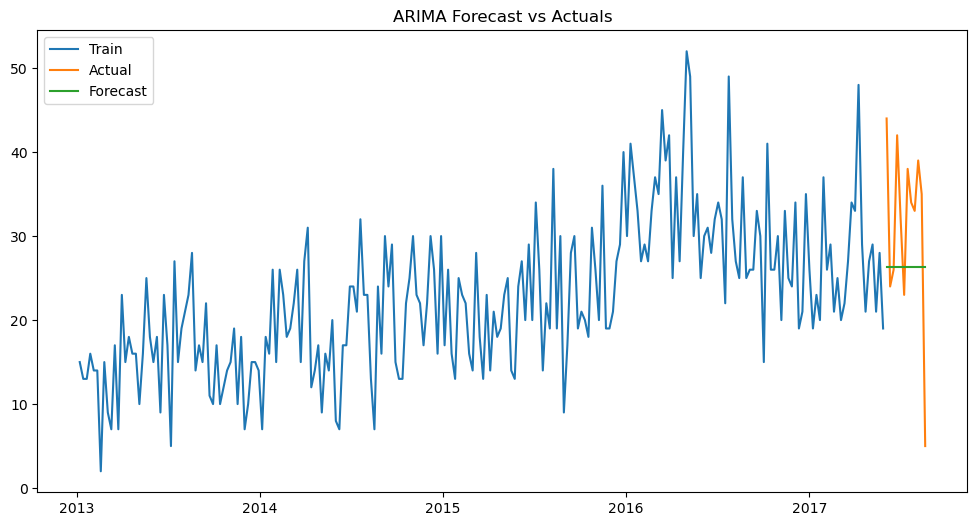

MAE: 9.50
RMSE: 11.35


In [7]:
# Forecast for the test period
forecast = model.predict(n_periods=len(test))
test['predicted_sales'] = forecast

# Plot actual vs predicted
import matplotlib.pyplot as plt

plt.figure(figsize=(12,6))
plt.plot(train.index, train['sales'], label='Train')
plt.plot(test.index, test['sales'], label='Actual')
plt.plot(test.index, test['predicted_sales'], label='Forecast')
plt.title('ARIMA Forecast vs Actuals')
plt.legend()
plt.show()

# Evaluate
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

mae = mean_absolute_error(test['sales'], test['predicted_sales'])
rmse = np.sqrt(mean_squared_error(test['sales'], test['predicted_sales']))

print(f"MAE: {mae:.2f}")
print(f"RMSE: {rmse:.2f}")


### Advanced modelling

### XGBoost

In [8]:
import pandas as pd

data1 = pd.read_parquet(
    r"C:\Users\navya\OneDrive\Documents\Retail-sales-forecasting\data\cleaned\merged_feature_engineered.parquet",
    engine="pyarrow"
)

data1.head()


,id,date,store_nbr,family,sales,onpromotion,city,state,type,cluster,...,dcoilwtico,sales_log,day_of_week,month,year,week_of_year,sales_last_week,sales_two_weeks_ago,rolling_4_weeks,rolling_8_weeks
0,0,2013-01-01,1,AUTOMOTIVE,0.0,0,Quito,Pichincha,D,13,...,93.14,0.000000,1,1,2013,1,NaN,NaN,NaN,NaN
1,1782,2013-01-02,1,AUTOMOTIVE,2.0,0,Quito,Pichincha,D,13,...,93.14,1.098612,2,1,2013,1,NaN,NaN,0.000000,0.000000
2,3564,2013-01-03,1,AUTOMOTIVE,3.0,0,Quito,Pichincha,D,13,...,92.97,1.386294,3,1,2013,1,NaN,NaN,1.000000,1.000000
3,5346,2013-01-04,1,AUTOMOTIVE,3.0,0,Quito,Pichincha,D,13,...,93.12,1.386294,4,1,2013,1,NaN,NaN,1.666667,1.666667
4,7128,2013-01-05,1,AUTOMOTIVE,5.0,0,Quito,Pichincha,D,13,...,93.12,1.791759,5,1,2013,1,NaN,NaN,2.000000,2.000000


#### Select Features and Target

In [9]:
# Target
y = data1['sales']

# Features: exclude id, date, and target
X = data1.drop(columns=['id', 'date', 'sales'])


#### Encode Categorical columns

In [10]:
categorical_cols = ["store_nbr", "family", "city", "state", "type", "cluster"]

for col in categorical_cols:
    X[col] = X[col].astype('category').cat.codes


#### Train/Test Split

In [11]:
from sklearn.model_selection import train_test_split

# Optional: sort by date to maintain time order
data1 = data1.sort_values('date')

# Split data (e.g., 95% train, 5% test)
split_index = int(len(data1) * 0.95)
X_train, X_test = X.iloc[:split_index], X.iloc[split_index:]
y_train, y_test = y.iloc[:split_index], y.iloc[split_index:]

print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)


X_train shape: (2901630, 19)
X_test shape: (152718, 19)


#### Train XGBoost Regressor

In [12]:
import xgboost as xgb
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

# Initialize XGBoost regressor
xgb_model = xgb.XGBRegressor(
    objective='reg:squarederror',  # regression task
    n_estimators=200,
    learning_rate=0.1,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    n_jobs=-1
)

# Train the model
xgb_model.fit(X_train, y_train)


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.8, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.1, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=6,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=200,
             n_jobs=-1, num_parallel_tree=None, ...)

#### Predict and Evaluate

In [13]:
# Make predictions
y_pred = xgb_model.predict(X_test)

# Evaluate
mae = mean_absolute_error(y_test, y_pred)
rmse = mean_squared_error(y_test, y_pred, squared=False)  

print(f"XGBoost Results:")
print(f"MAE : {mae:.2f}")
print(f"RMSE: {rmse:.2f}")


XGBoost Results:
MAE : 3.75
RMSE: 27.78


c:\Users\navya\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


### LightGBM

In [15]:


from lightgbm import LGBMRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

# Initialize LightGBM model
lgbm_model = LGBMRegressor(
    n_estimators=500,
    learning_rate=0.05,
    max_depth=8,
    num_leaves=64,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42
)

# Train the model
lgbm_model.fit(X_train, y_train)

# Predict
y_pred_lgbm = lgbm_model.predict(X_test)

# Evaluate performance
mae_lgbm = mean_absolute_error(y_test, y_pred_lgbm)
rmse_lgbm = np.sqrt(mean_squared_error(y_test, y_pred_lgbm))

print("LightGBM Results:")
print(f"MAE : {mae_lgbm:.2f}")
print(f"RMSE: {rmse_lgbm:.2f}")


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.200779 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2213
[LightGBM] [Info] Number of data points in the train set: 2901630, number of used features: 19
[LightGBM] [Info] Start training from score 369.428094
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best g

In [16]:
import pandas as pd

# Create a dictionary with results
results = {
    "Model": ["ARIMA", "XGBoost", "LightGBM"],
    "MAE": [9.50, 3.75, 2.19],
    "RMSE": [11.35, 27.78, 21.21]
}

# Convert to DataFrame
results_df = pd.DataFrame(results)

# Display the comparison table
print("Comparison of Model Performance:")
print(results_df)


Comparison of Model Performance:
      Model   MAE   RMSE
0     ARIMA  9.50  11.35
1   XGBoost  3.75  27.78
2  LightGBM  2.19  21.21


### Saving models

In [21]:
import joblib

# Save XGBoost model
joblib.dump(xgb_model, "xgboost_model.pkl")

# Save LightGBM model
joblib.dump(lgbm_model, "lightgbm_model.pkl")

# Save the fitted auto_arima model
joblib.dump(model, "arima_model.pkl")


['arima_model.pkl']

### Model Evaluation

I evaluated the models using **Mean Absolute Error (MAE)** and **Root Mean Squared Error (RMSE)**. These metrics are suitable for this regression problem because:

- **MAE** measures the average absolute difference between predicted and actual sales, giving a clear, interpretable estimate of forecast accuracy.  
  - Example: For LightGBM, MAE = 2.19 → on average, the model's predictions are off by 2.19 units.

- **RMSE** penalizes larger errors more heavily, which is important in retail forecasting where large under- or over-predictions can be costly.  
  - Example: For LightGBM, RMSE = 21.21 → large errors are reflected in this value, showing the model's sensitivity to spikes in sales.

### Performance Comparison

| Model      | MAE   | RMSE  |
|----------- |------ |------ |
| ARIMA      | 9.50  | 11.35 |
| XGBoost    | 3.75  | 27.78 |
| LightGBM   | 2.19  | 21.21 |

### Challenges Addressed

- **Scale:** Sales vary widely across products and stores. Using MAE and RMSE helps measure accuracy fairly across this range.  
- **Seasonality:** Weekly, monthly, and yearly patterns are captured using time-based features (`day_of_week`, `month`, `week_of_year`) and lag features (`sales_last_week`, `sales_two_weeks_ago`, rolling averages).  
- **Generalization:** Including store, product, and cluster information allows the model to learn patterns that generalize across all stores and product categories.

**Conclusion:**  
LightGBM performs the best among the models tested, giving the lowest MAE and a competitive RMSE. The engineered features successfully capture seasonality and store/product-specific patterns.
